# European Put options using Finite Element Method for BSM Model

### Set Option Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
r=0.05 
T=0.5
sigma=0.4
K=100
q=(2*r)/(sigma)**2

### Solve for P

In [2]:
N=1000;
M=500;
xmin=-13;
xmax=10;
x=np.linspace(start=xmin, stop= xmax,num=N+2) # 1002 x 1
x_eff= x[1:len(x)-1] # 1000 x 1
dx=x[1]-x[0]
tau_v= np.linspace(start= 0, stop= T*(sigma**2)/2, num = M+1) # 1 x 501
dtau=tau_v[1]-tau_v[0]

# reshaping into row and column vector
x.shape = (N+2,1)
x_eff.shape = (N,1)
tau_v.shape= (1, M+1)

w=np.zeros((N,M+1)) # 1000 x 501
b=np.zeros((N,M+1))

# Get Boundary condition in general form.
Beta= lambda tau:0
Alpha= lambda tau :np.exp(0.5*(q-1)*xmax+0.25*((q-1)**2)*tau)
dAlpha=lambda tau: (0.25*(q-1)**2)*Alpha(tau)
Phi_b= lambda xx,tau: np.multiply((Beta(tau)-Alpha(tau)),((xx-xmin)/(xmax-xmin)))+Alpha(tau) # elementwise multiplication

# Set initial condition.
Gamma= lambda x: np.maximum(np.exp(x*0.5*(q-1))- np.exp(x*0.5*(q+1)), 0)
w[:,0]= (Gamma(x_eff)-Phi_b(x_eff,0)).ravel()

In [3]:
# Set b as a matrix
Fun_b=lambda xx,tau: dx*(((xx-xmin)/(xmax-xmin))*(-dAlpha(tau))+dAlpha(tau))
for i in range(M+1):       
    b[:,i]=(Fun_b(x_eff,tau_v[0,i])).ravel()

In [4]:
def SetupA(N,h):
    A=np.zeros((N,N))
    temp = [-1,2,-1]
    for i in range(1,N-1):
        A[i,i-1:i+2]=temp
    A[0,0:2]=[2,-1]
    A[N-1,N-2:N]=[-1,2]
    A=(1/h)*A
    StiffnessM=A
    return StiffnessM

In [5]:
def SetupB(N,h):
    B=np.zeros((N,N))
    temp = [1,4,1]
    for i in range(1,N-1):
        B[i,i-1:i+2]=temp
    B[0,0:2]=[4,1]
    B[N-1,N-2:N]=[1,4]
    B=(h/6)*B
    MassM=B
    return MassM

In [6]:
# Get Matrix A&B. As of 5.11(b)(c)
Temp1=SetupB(N,dx)+(dtau/2)*SetupA(N,dx)
Temp3=SetupB(N,dx)-(dtau/2)*SetupA(N,dx)
Temp2=np.linalg.inv(Temp1)


In [7]:
# % Solve for w
for i in range(1,M+1):
    consta= Temp3.dot(w[:,i-1])        
    constb = (b[:,i]+b[:,i-1])       
    constc = (consta-(dtau/2)*constb)
    constd= Temp2.dot(constc)
    w[:,i]= constd

### GetNodes

In [8]:
#  This script is to get solution value on the nodes for the purpose of interpolation.
#  Get nodes value
Base=np.zeros((N+2, M+1))
for i in range(N+2):
    for j in range(M+1):
        const_x = x[i,0]
        const_tau = tau_v[0,j] 
        Base[i,j]=Phi_b(const_x,const_tau)
Nodes_y = np.r_[np.zeros((1, M+1)),w, np.zeros((1, M+1))] + Base
Nodes_v=np.empty((N+2, M+1))
temp_Ax=(-0.5)*(q-1)*x
temp_Atau=(-0.25)*((q+1)**2)*tau_v
for i in range(N+2):
    for j in range(M+1):
        Nodes_v[i,j]=Nodes_y[i,j]*(K*np.exp(temp_Ax[i,0] + temp_Atau[0,j]))

## Solution Surface for European Put 

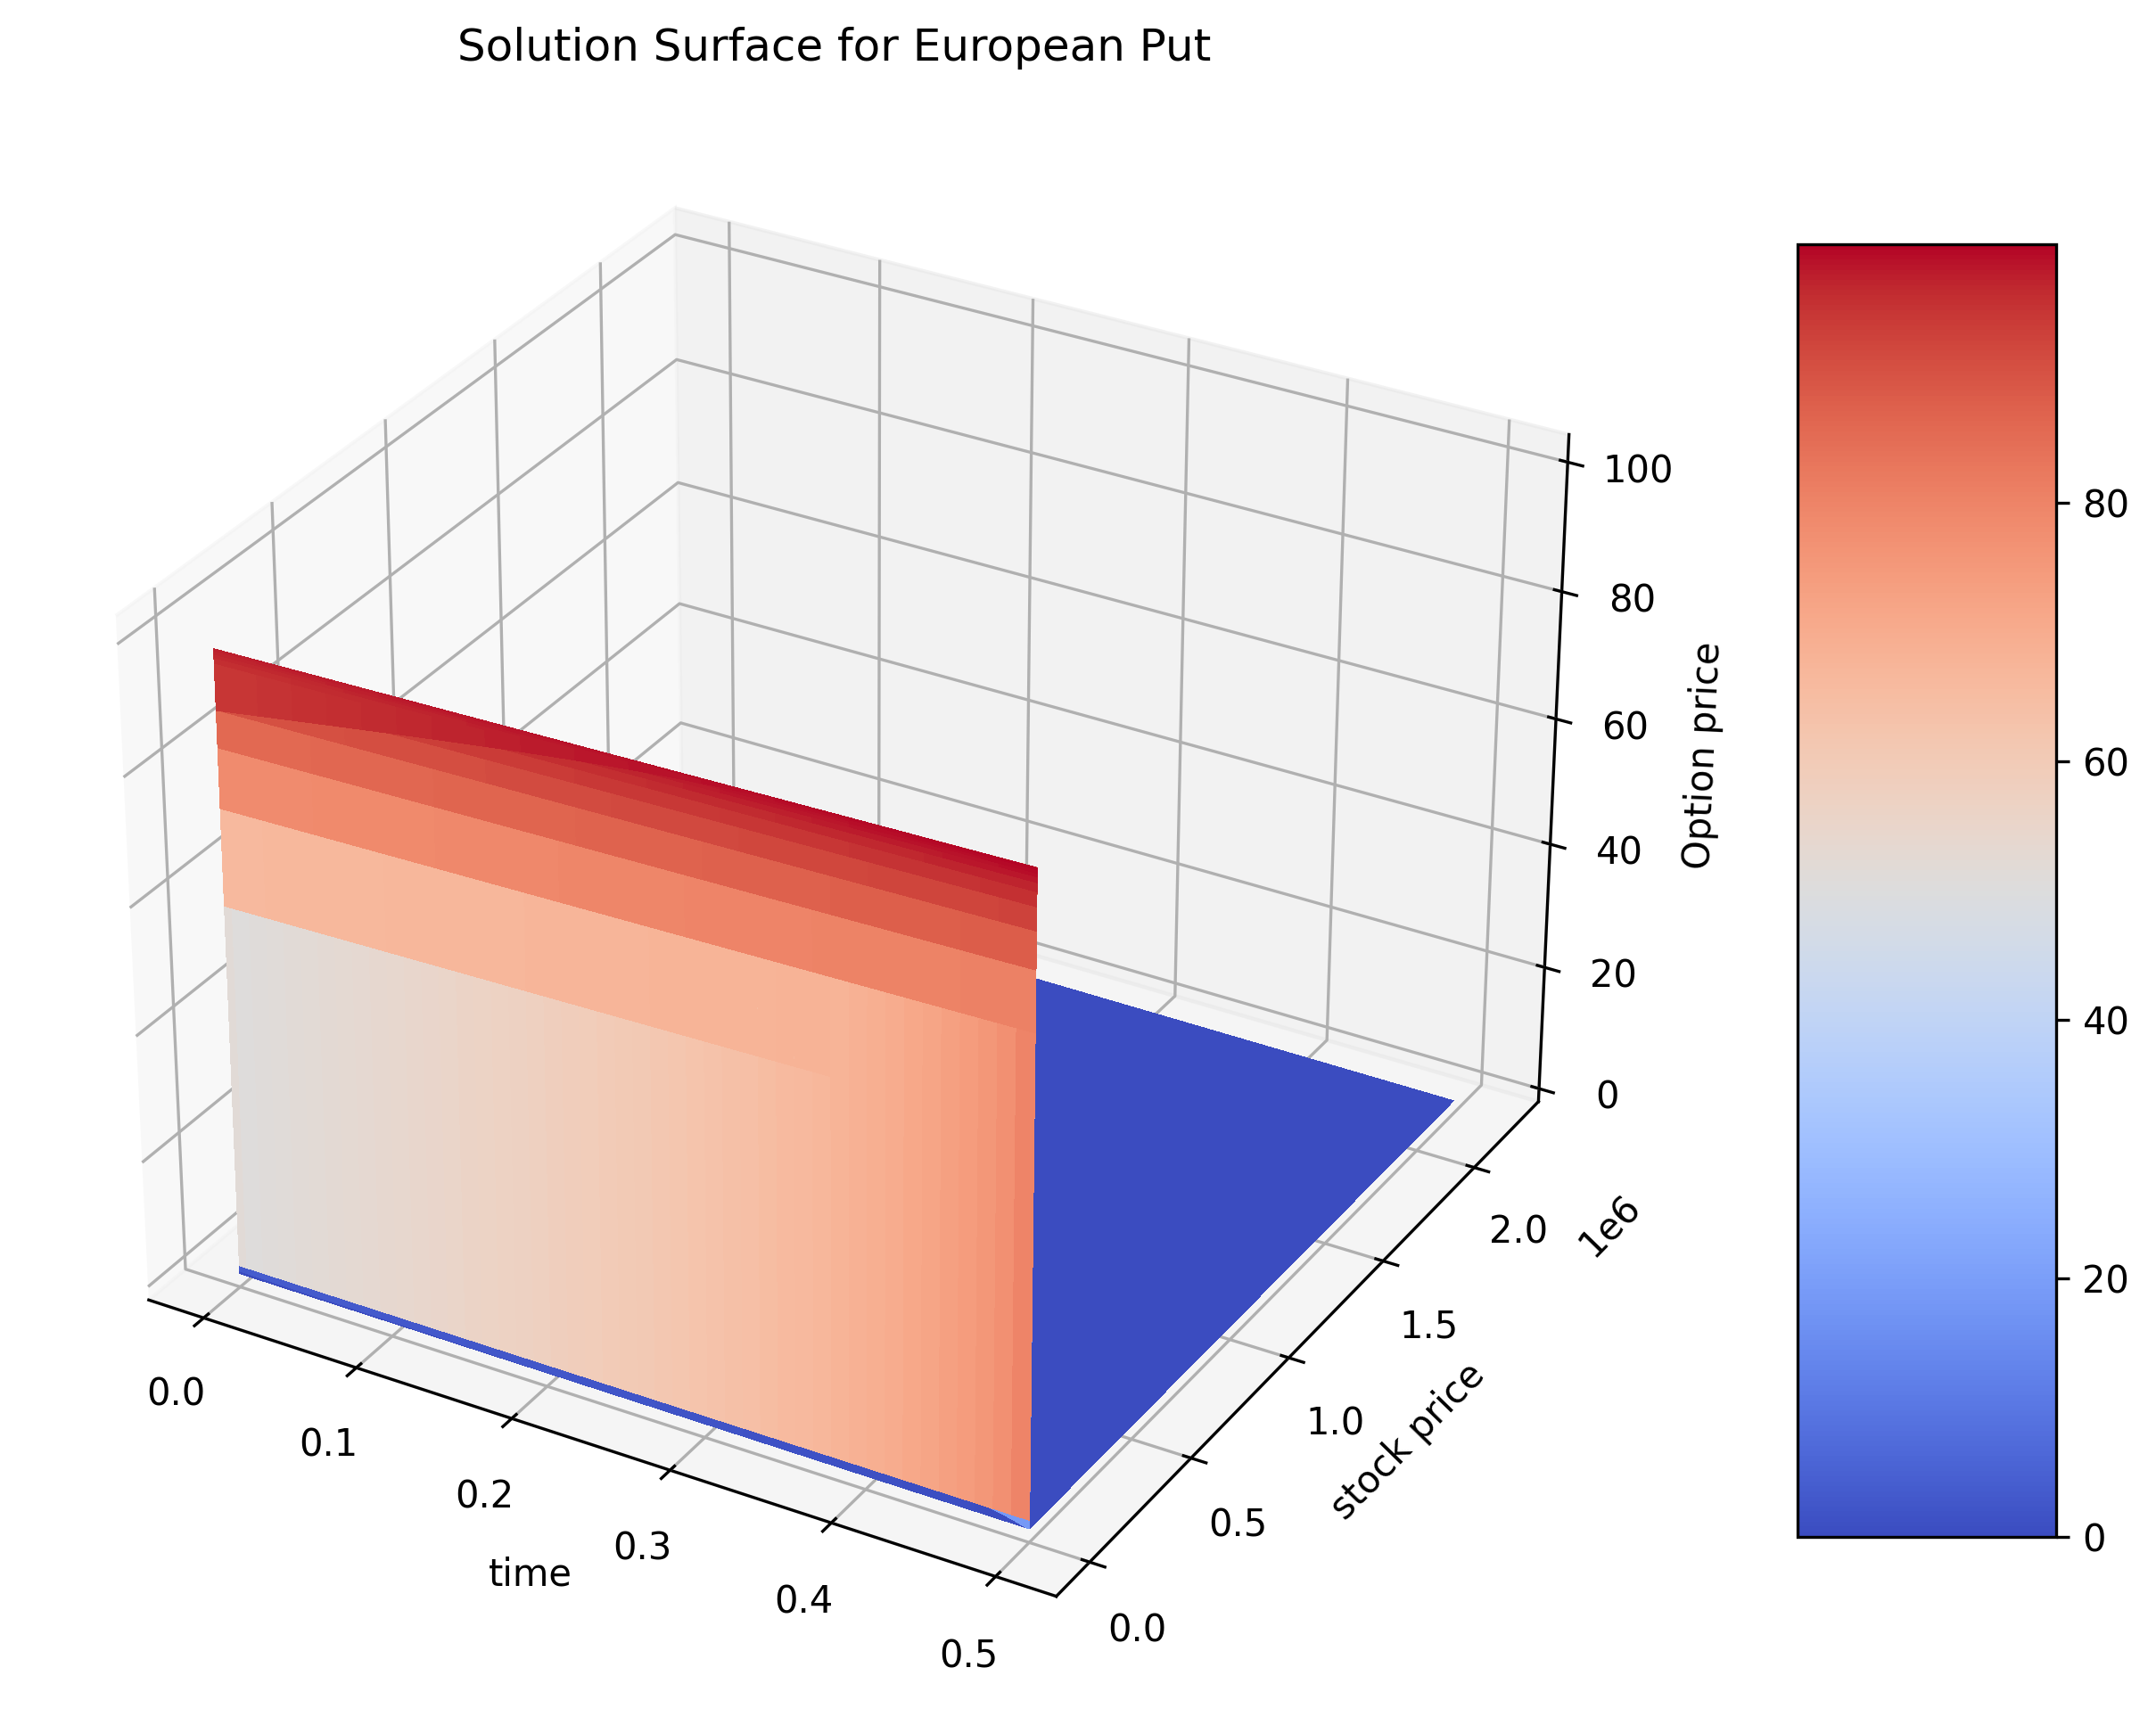

In [26]:
from matplotlib import cm
stock = K*np.exp(x) # 1002 x 1
time = (T-tau_v*2/sigma**2).T # 501 x 1
fig = plt.figure(figsize=(15,8), dpi= 300)
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(time.ravel(), stock.ravel())
Z = Nodes_v
surf= ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(Z.min(),Z.max())
ax.set_xlabel('time')
ax.set_ylabel('stock price')
ax.set_zlabel('Option price')
ax.set_title('Solution Surface for European Put')
plt.colorbar(surf, shrink=0.8, aspect=5)
plt.show()

##  European Put : Comparision between initial and maturity period

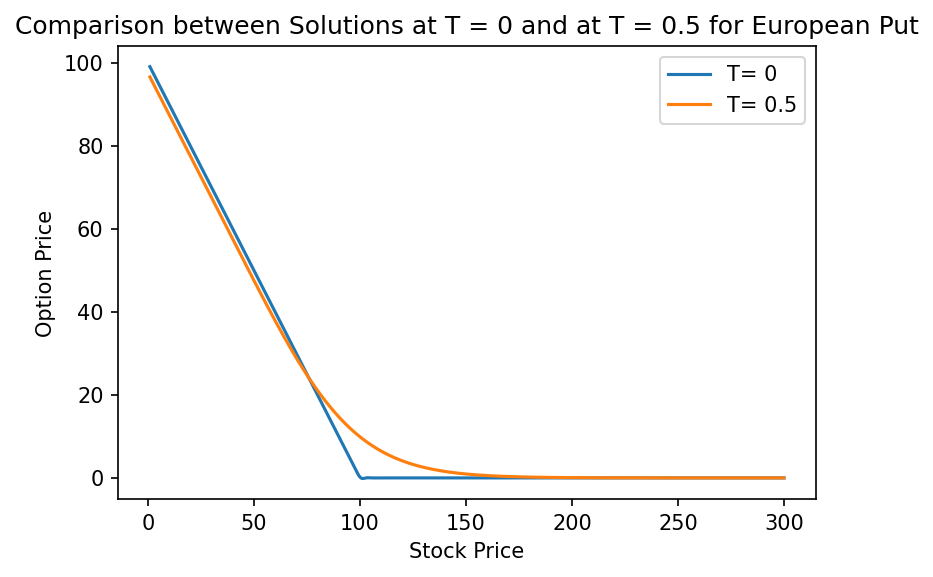

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
plt.figure(dpi= 150)

s_res=np.linspace(1,300,1000)
x_res=np.log((1/K)*s_res)

# at T=0.5
inter_fxn1 = scipy.interpolate.interp1d(x.ravel(), Nodes_v[:,M].ravel(), kind='cubic')
y_res_terminal = inter_fxn1(x_res)

# at T= 0
inter_fxn2 = scipy.interpolate.interp1d(x.ravel(), Nodes_v[:,0].ravel(), kind='cubic')
y_res_initial = inter_fxn2(x_res)

plt.plot(s_res, y_res_initial, label='T= 0')
plt.plot(s_res, y_res_terminal, label='T= 0.5')
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("Comparison between Solutions at T = 0 and at T = 0.5 for European Put")
plt.legend(loc='best')
plt.show()


## European Put : FEM Solution vs Exact Solution 

In [11]:
from scipy import stats
def Nd1(S,K,T,r,sigma):    
    return (np.log(S/K)+(r+sigma*sigma/2.)*T)/(sigma*np.sqrt(T))

def Nd2(S,K,T,r,sigma):
    d1 = Nd1(S,K,T,r,sigma) 
    return d1-sigma*np.sqrt(T)

def call(S,K,T,r,sigma):
    d1 = Nd1(S,K,T,r,sigma)
    d2 = Nd2(S,K,T,r,sigma)
    c = (S*stats.norm.cdf(d1))-(K*np.exp(-r*T)*stats.norm.cdf(d2))
    return c

def put(S,X,T,r,sigma):
    p= X*np.exp(-r*T)-S+call(S,X,T,r,sigma)    
    return p

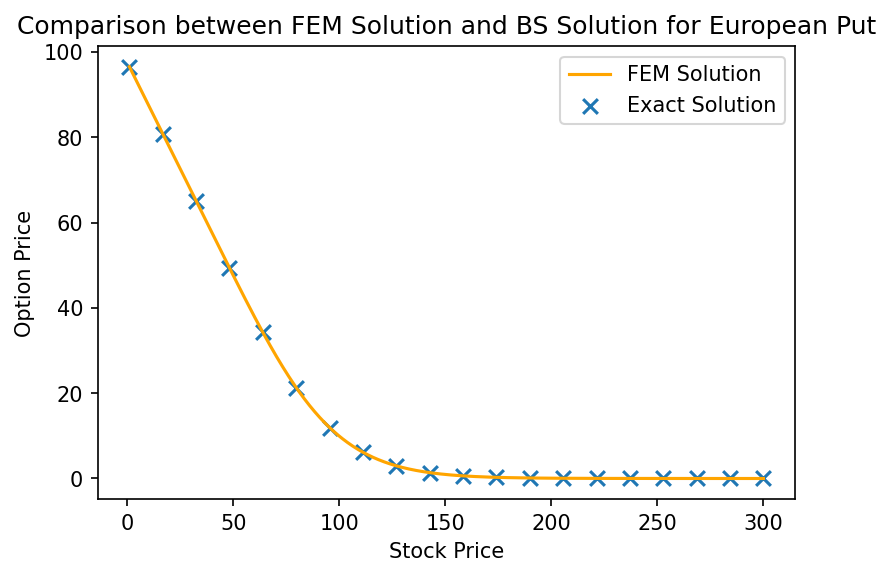

In [12]:
# FEM
s_res=np.linspace(1,300,1000)
x_res=np.log((1/K)*s_res)

inter_fem = scipy.interpolate.interp1d(x.ravel(), Nodes_v[:,M].ravel(), kind='cubic')
y_res_fem = inter_fem(x_res)

# Exact using BS formula
s_res_exact= np.linspace(1,300,20)
y_exact=put(s_res_exact,K,T,r,sigma)

plt.figure(dpi= 150)
plt.plot(s_res, y_res_fem, label='FEM Solution', color= 'orange')
plt.scatter(s_res_exact, y_exact, s=50, marker = 'x', label='Exact Solution')
plt.title('Comparison between FEM Solution and BS Solution for European Put')
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.legend(loc='best')
plt.show()